## Introduction {.unnumbered}

In the [part 1 CrimeGraph notebook](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/), we prepared city street segment data for use in training a graph deep learning model to forecast the risk of violent crime.

In this notebook, we will prepare temporal data describing the street segments and times when crimes occur, using geocoded event data provided by [SpotCrime](https://spotcrime.com/).

As before, we are following the GLDNet^[Gated Localized Diffusion] architecture described in the 2020 paper _[Graph Deep Learning Model for Network-based Predictive Hotspot Mapping of Sparse Spatio-Temporal Events](https://discovery.ucl.ac.uk/id/eprint/10085742/)_ architecture.

The code is available on [GitHub](https://github.com/subelsky/crimegraph).

## Load the Event Data

SpotCrime events were provided in CSV^[Comma-Separated Values, a common way to represent tabular information in a text-based format] format. The events were extracted from a variety of sources, including 911 reports and media reports. Each event includes several fields, but the ones of interest to us are `Date`, `Type`, `Latitude`, and `Longitude`.

In [2]:
import os
import pandas as pd

events_path = '../../data/spotcrime/'
dataframes = []

# Walk through each SpotCrime CSV file and append to our list of events
with os.scandir(events_path) as entries:
    for file in sorted(entries, key=lambda entry: entry.name):
        file_path = events_path + file.name

        if not file_path.endswith('.csv'):
            continue

        print(file_path)
        
        rows = pd.read_csv(file_path, na_filter=False, keep_default_na=False, index_col=False)
        dataframes.append(rows)

# combine all of the individual event dataframes into a single large dataframe
events = pd.concat(dataframes, ignore_index=True)

# Because the Date column includes time information, and we are only looking
# at daily retrodictions and predictions, we can discard the time information
events['Date'] = events['Date'].str.split(' ', expand=True)[0]
events['Date'] = pd.to_datetime(events['Date'], format='ISO8601')

print(f'\n{len(events)} events loaded')

../../data/spotcrime/2015-Baltimore-MD.csv
../../data/spotcrime/2016-Baltimore-MD.csv
../../data/spotcrime/2017-Baltimore-MD.csv
../../data/spotcrime/2018-Baltimore-MD.csv
../../data/spotcrime/2019-Baltimore-MD.csv
../../data/spotcrime/2020-Baltimore-MD.csv
../../data/spotcrime/2021-Baltimore-MD.csv
../../data/spotcrime/2022-Baltimore-MD.csv
../../data/spotcrime/2023-Baltimore-MD.csv

2806668 events loaded


Now we can remove extraneous columns - although some of these could be potentially useful as features for a future model. For example, `Description` could be analyzed using natural language processing techniques.

In [3]:
events.drop(columns=[
    'ID', 'Address', 'City', 'State', 'Country', 'Zip', 'Description', 'Case#', 'Incident#', 'Report#', 'Call#',
    'Other#', 'Link', 'Source', 'CallsForService', 'NewsStory'
], inplace=True)

## Event Distribution Analysis

Feature engineering is about carefully selecting which data channels to present the model, and which to discard. The signal from some channels may overwhelm the signal from other, more predictive channels, and every channel adds to both the complexity of the model and the cost of training.

So far, we've already compressed the time dimension (stored in the `Date` column) into single-day timesteps. There are also channels for `Type`:

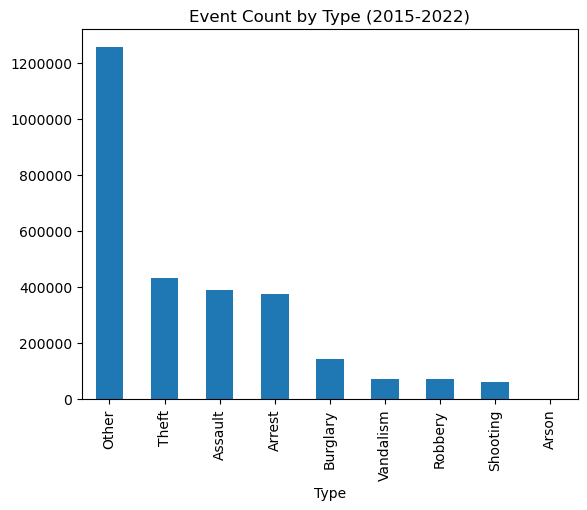

In [4]:
#| code-fold: true
import matplotlib.pyplot as plt

events.value_counts('Type').plot(kind='bar', title='Event Count by Type (2015-2022)')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

 Nine categories are probably too many for the scope of this experiment, and not all are likely to be equally predictive of violence.

 If we were to use all nine categories, we would be presenting the model with a 9-dimensional feature vector^[Meaning there would be a list of nine numbers, for each node, for each day] for each node on each day. This would be a very sparse representation, because most nodes will have zero events of a given type at any given timestep.
 
 We can reduce the dimensionality of the feature vector by combining categories that are similar: `Assault`, `Robbery`, and `Shooting` can be combined as type `Violent`, while `Arson`, `Burglary`, `Theft`, and `Vandalism` can be combined as feature `Property`.
 
 `Arrest` seems worth preserving as a distinct feature, but the `Other` category is so general and dominant that it is not likely to be predictive of violence, so we can discard it. This would be a fruitful area for future experiments, perhaps by using natural language processing on the `Description` field of `Other` events to generate more specific classifications.

In [5]:
# Remove Other since it is generic and dominates the other categories
events = events[~events['Type'].isin(['Other'])]

# Reduce dimensionality of Assault, Robbery, and Shooting
violent_crime_types = ['Assault', 'Robbery', 'Shooting']
events['Type'] = events['Type'].replace(violent_crime_types, 'Violent')

# Reduce dimensionality of Arson, Burglary, Vandalism, and Theft
property_crime_types = ['Arson', 'Burglary', 'Vandalism', 'Theft']
events['Type'] = events['Type'].replace(property_crime_types, 'Property')

print(f'{len(events)} primary events after filtering out "Other"')

1549308 primary events after filtering out "Other"


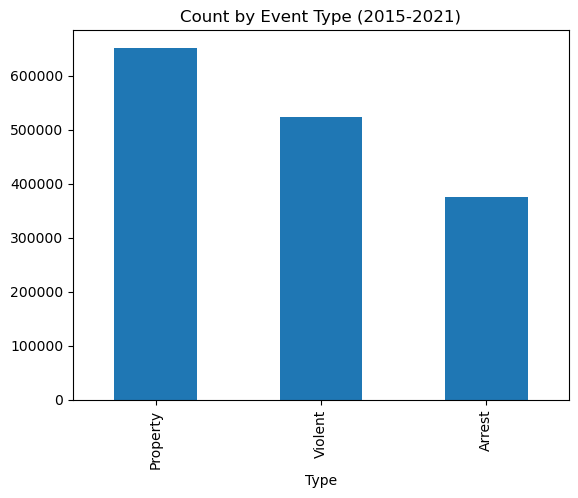

In [6]:
#| code-fold: true
events.value_counts('Type').plot(kind='bar', title='Count by Event Type (2015-2021)')
None

## Build Event Geometry

The SpotCrime data includes `Latitude` and `Longitude` values as strings of of numbers. In order to assign crime events to a street segment, we need to convert those coordinates into a point geometry that can be used with our street graph. The [geopandas](https://geopandas.org/) library provides a way to store the event data as geometric objects, in a `GeoDataFrame`.

In [7]:
import geopandas as gpd
from shapely.geometry import Point

# Convert our events dataframe into to a geopandas dataframe by composing a
# 'geometry' column from the 'Latitude' and 'Longitude' columns
events['geometry'] = events.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
events.drop(columns=['Latitude', 'Longitude'], inplace=True)

events_gdf = gpd.GeoDataFrame(events)
events_gdf.head()

,Date,Type,geometry
0,2015-01-01,Violent,POINT (-76.60609 39.29915)
1,2015-01-01,Violent,POINT (-76.61247 39.30823)
2,2015-01-01,Violent,POINT (-76.56809 39.35307)
3,2015-01-01,Violent,POINT (-76.63680 39.28982)
4,2015-01-01,Violent,POINT (-76.58299 39.36264)


The event locations are specified in spherical coordinates (hours/minutes/seconds), using a coordinate reference system called [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System), while the street graph we created in [part 1](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/) uses a planar coordinate reference system called [NAD83](https://epsg.io/26985). `NAD83` enables us to treat the city as a flat surface, so that we can compute linear distances in meters.

In [8]:
# Original SpotCrime coordinates given  WGS84, aka EPSG:4326 spherical coordinates
events_gdf.crs = 'EPSG:4326'

# Convert 'geometry' column to planar coordinates NAD 83 (aka EPSG:26985)
events_gdf = events_gdf.to_crs('EPSG:26985')
events_gdf.head()

,Date,Type,geometry
0,2015-01-01,Violent,POINT (433977.600 181288.835)
1,2015-01-01,Violent,POINT (433423.454 182294.867)
2,2015-01-01,Violent,POINT (437227.394 187290.304)
3,2015-01-01,Violent,POINT (431332.752 180242.042)
4,2015-01-01,Violent,POINT (435937.871 188346.235)


## Restrict Geographic Scope of Events

 In part 1, we limited the scope of interest to a bounding box across a swath of the city in order to reduce the computational demands of the experiment. In this step, we remove events that fall outside of that bounding box.

In [11]:
from lib.geo_utils import filter_gdf

# this is the same box used to constrain the street graph in step 1
minLat, maxLon = 39.293781858831856, -76.61436168242447
maxLat, minLon = 39.354471979447325, -76.6798709073914

filtered_events_gdf = filter_gdf(events_gdf, minLat=minLat, minLon=minLon, maxLat=maxLat, maxLon=maxLon)

print(f'{len(filtered_events_gdf)} events in central Baltimore')

399255 events in central Baltimore


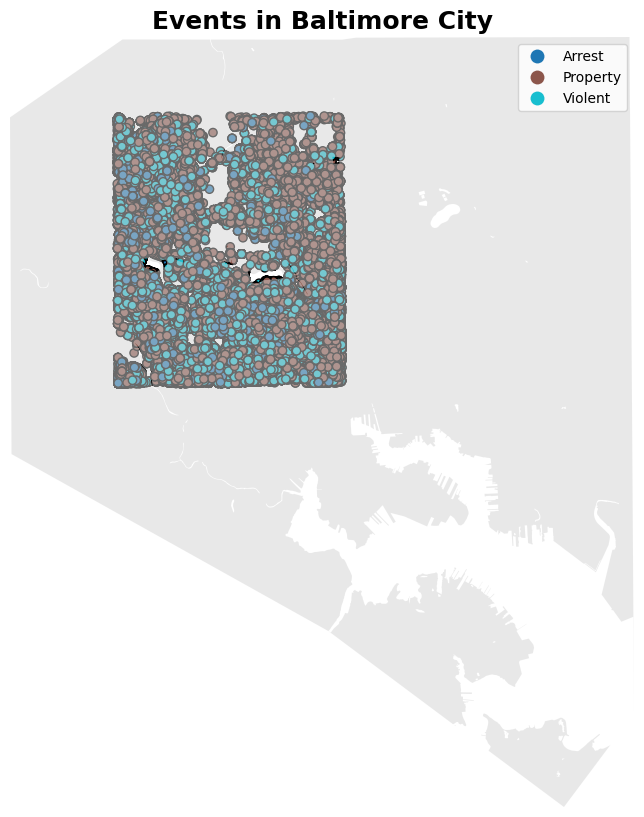

In [12]:
#| code-fold: true
from lib.plots import plot_events_on_map

plot_events_on_map(filtered_events_gdf)

## Associate Crime Events With Street Segment Nodes

Now that we have a prepared a set of events with planar coordinates, we can use the street graph built in part 1 to associate events with nearby street segments.

In [13]:
import pickle

with open('../../data/processed/baltimore_street_graph.gpickle', 'rb') as file:
    G = pickle.load(file)

The street segment nodes in the graph look like this:

In [14]:
#| code-fold: true
print(f'{len(G)} nodes in the street graph')
print()

for node in list(G.nodes.data())[None:5:None]:
    print(node)

1177 nodes in the street graph

(0, {'NodeID': 367225, 'name': 'N DUKELAND ST', 'position': (429023.8628222718, 181450.00684655222)})
(1, {'NodeID': 367456, 'name': 'W READ ST', 'position': (433112.90626279684, 181374.68178852845)})
(2, {'NodeID': 367483, 'name': 'REMINGTON AVE', 'position': (432440.1964178119, 184064.86845014035)})
(3, {'NodeID': 367488, 'name': 'CANTERBURY RD', 'position': (432716.56154741155, 185417.96152212998)})
(4, {'NodeID': 367592, 'name': 'SWEET AIR ST', 'position': (431223.7876548111, 184620.00943614714)})


While the edges that represent intersections between streets looks like this:

In [15]:
#| code-fold: true
# sanity check that the edges were loaded properly
edges = [(u, v) for u, v, data in G.edges(data=True)]

print(f'{len(edges)} edges in the street graph')
list(G.edges.data())[None:5:None]

3469 edges in the street graph


[(0, 89, {'distance': 207.24859639546855, 'weight': 0.9625401124585142}),
 (0, 169, {'distance': 170.25866131463928, 'weight': 0.9745620176687882}),
 (0, 256, {'distance': 287.5199729004246, 'weight': 0.9291524699760467}),
 (0, 498, {'distance': 581.1777592139317, 'weight': 0.7406420337058561}),
 (0, 545, {'distance': 76.50819939674132, 'weight': 0.9948103975797566})]

We now create a GeoDataFrame using the positions of each node, in order to intersect the node locations with the event locations.

In [16]:
nodes_gdf = gpd.GeoDataFrame(index=[n for n in G.nodes()],
                             geometry=[Point(data['position']) for n, data in G.nodes(data=True)],
                             crs=events_gdf.crs)

nodes_gdf.head()

,geometry
0,POINT (429023.863 181450.007)
1,POINT (433112.906 181374.682)
2,POINT (432440.196 184064.868)
3,POINT (432716.562 185417.962)
4,POINT (431223.788 184620.009)


The `associate_events_with_nodes()` function used below is responsible for matching a geolocated event to the nearest geolocated street segment node. The source code can be [found on GitHub](https://github.com/subelsky/crimegraph).

In [17]:
# Use library code to create a new events dataframe, containing the original events
# but with an additional NodeIndex column pointing to the identity of the street
# segment node closest to the event location
from lib.events import associate_events_with_nodes

events_with_nodes_gdf = associate_events_with_nodes(filtered_events_gdf.copy(), nodes_gdf)
events_with_nodes_gdf

,Date,Type,geometry,NodeIndex
7,2015-01-01,Violent,POINT (428368.865 182349.618),288
12,2015-01-01,Property,POINT (430963.824 181421.084),582
13,2015-01-01,Property,POINT (428015.798 184610.740),170
18,2015-01-01,Property,POINT (429846.032 181657.117),54
21,2015-01-01,Property,POINT (433041.674 182688.032),421
...,...,...,...,...
2806079,2023-11-06,Violent,POINT (429744.196 181555.260),904
2806082,2023-11-06,Violent,POINT (429868.726 181220.342),518
2806096,2023-11-06,Violent,POINT (427652.695 187341.454),604
2806106,2023-11-06,Violent,POINT (429810.588 181562.061),904


## Perform Sanity Checks

In [18]:
#| code-fold: true
# Perform some sanity checks
unique_node_count = events_with_nodes_gdf.value_counts('NodeIndex').count()
nodes_with_zero_events = nodes_gdf[~nodes_gdf.index.isin(events_with_nodes_gdf['NodeIndex'])]

print(f'{unique_node_count} unique nodes associated with at least one crime event')
print(f'{len(nodes_with_zero_events)} nodes with zero events')

1101 unique nodes associated with at least one crime event
76 nodes with zero events


In [19]:
#| code-fold: true
# Aggregate crimes by their nearest node ID to get the sum total for each node
crime_count_per_node = events_with_nodes_gdf.groupby('NodeIndex').size()

# Merge this count with the nodes GeoDataFrame
merged_nodes_gdf = nodes_gdf.merge(crime_count_per_node.rename('crime_count'), left_index=True, right_index=True, how='left')

# drop nodes that have no crimes, since this is only for display purposes
merged_nodes_gdf.dropna(subset=['crime_count'], inplace=True)

This plot shows the results of our work so far. All crime events have been fixed to a specific street segment node, and the plot looks reasonable.

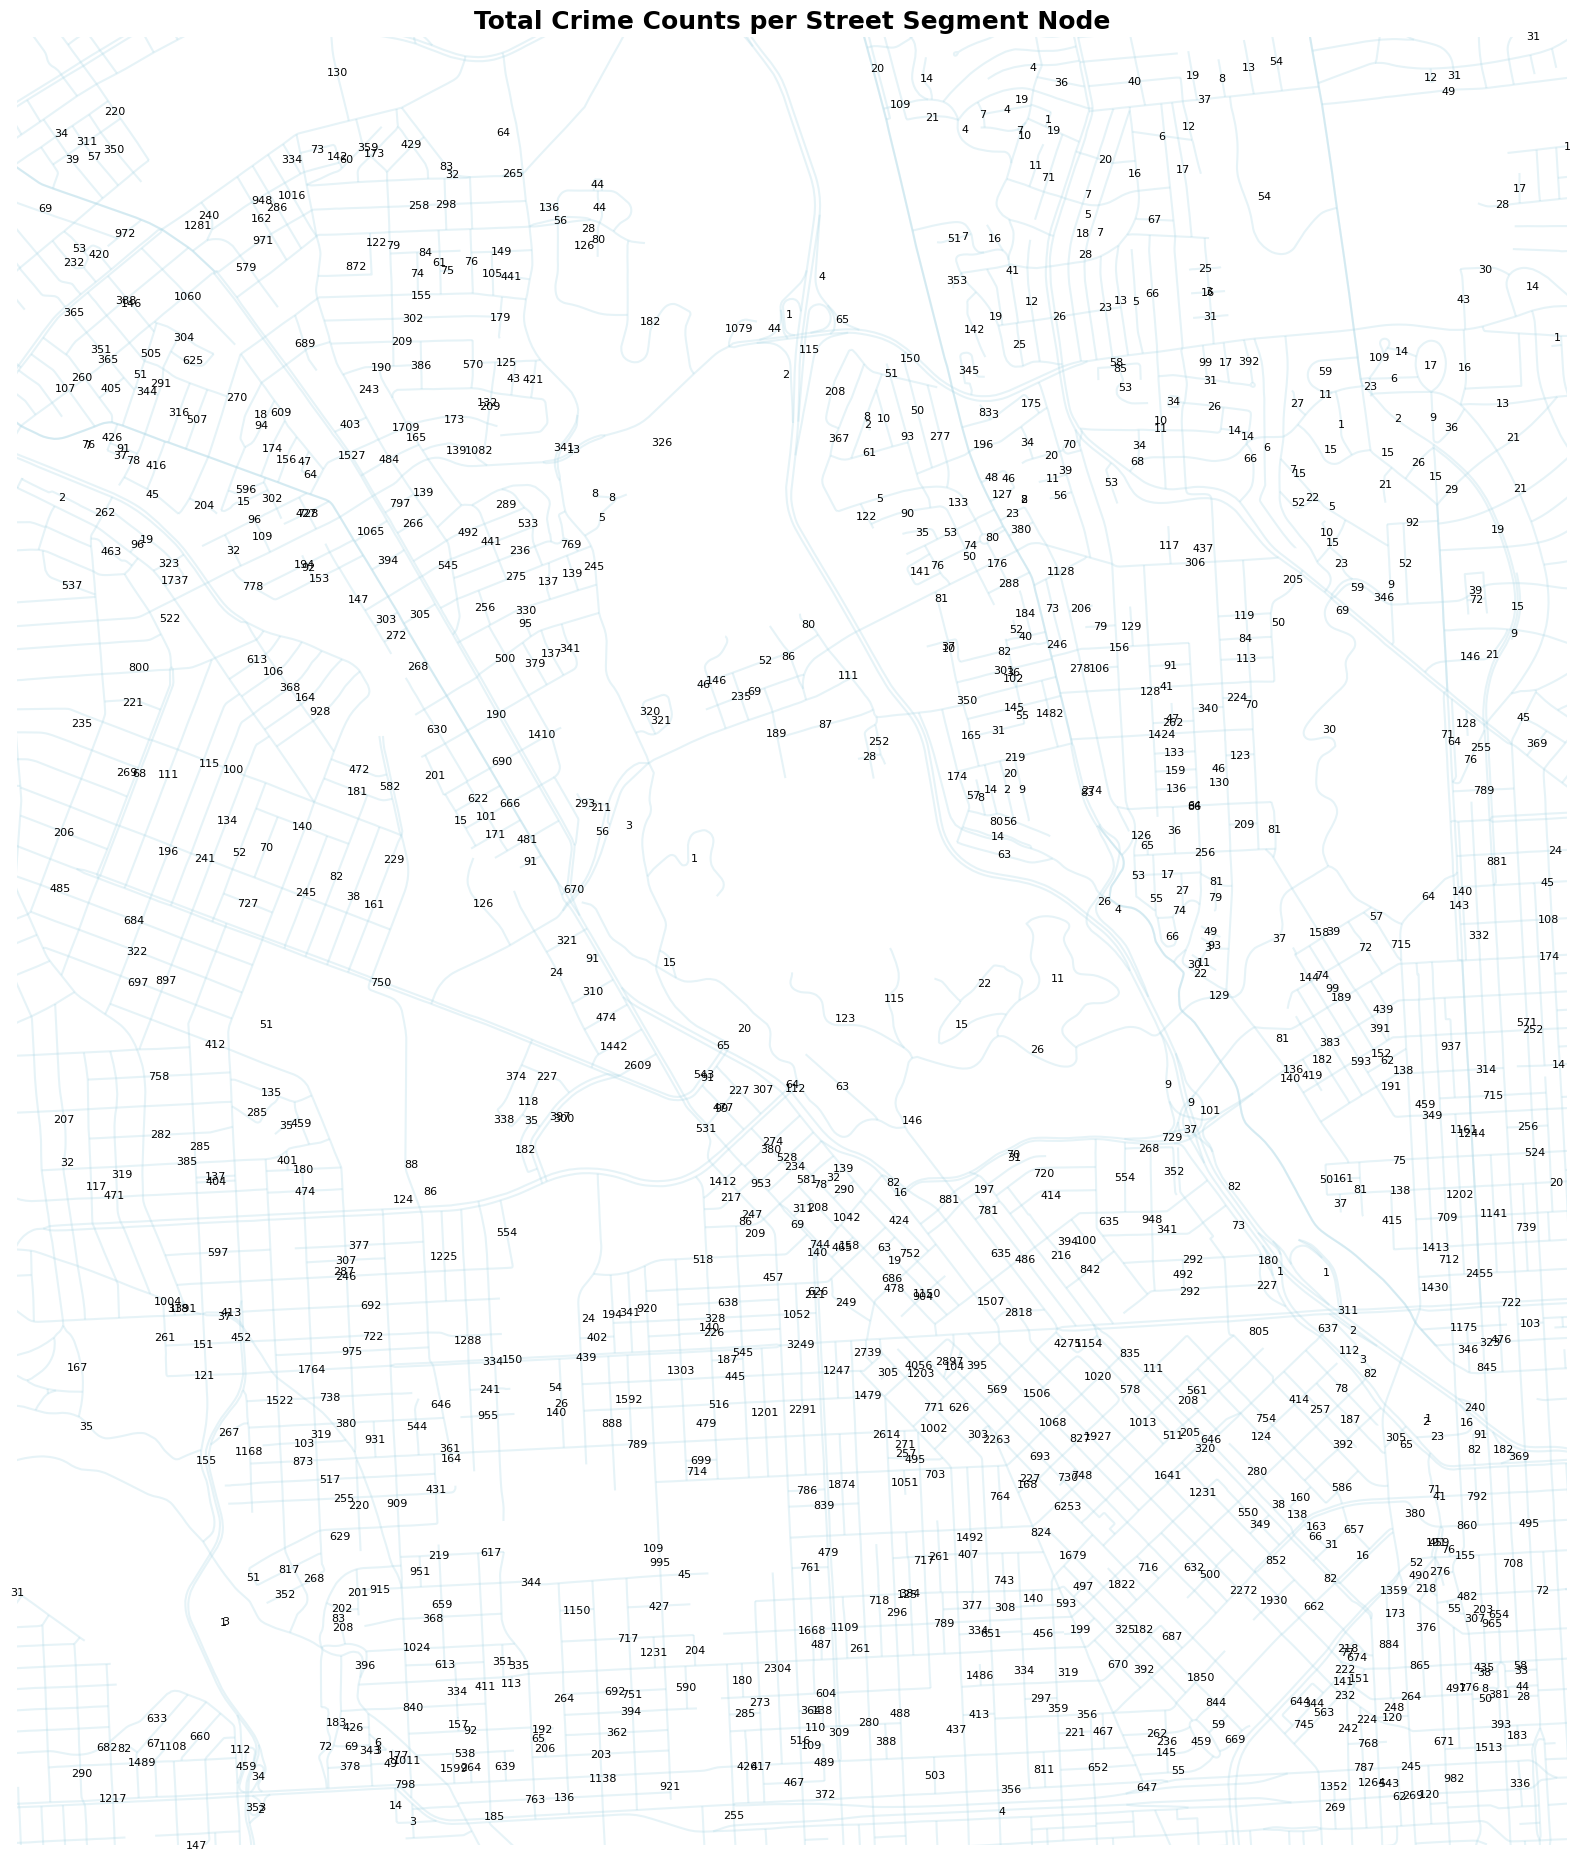

In [20]:
#| code-fold: true
from tkinter import font
import matplotlib.pyplot as plt

city_gdf = gpd.read_file('../../data/city_streets/MDOT_Know_Your_Roads.shp')
city_gdf = city_gdf.to_crs(epsg=26985)

fig, ax = plt.subplots(figsize=(20, 30))

city_gdf.plot(ax=ax, color='lightblue', alpha=0.3)

for idx, row in merged_nodes_gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, str(int(row.crime_count)), fontsize=8, ha='center', va='center')

minLong, minLat, maxLong, maxLat = merged_nodes_gdf.total_bounds

ax.set_xlim(minLong, maxLong)
ax.set_ylim(minLat, maxLat)

ax.axis('off')  

plt.title('Total Crime Counts per Street Segment Node', fontsize=18, fontweight='bold')
plt.show()

## Create Timesteps

We now need to reorganize the events dataframe into a series of daily snapshots that aggregate crime counts into a feature vector for each node, suitable for training the model and for using the model to make predictions.

In [21]:
# Group events by Date and NodeIndex to get the number of events of each type
timesteps = events_with_nodes_gdf.pivot_table(
    index=['Date', 'NodeIndex'],
    columns='Type',
    aggfunc='size',
    fill_value=0
)

timesteps

Type                  Arrest  Property  Violent
Date       NodeIndex                           
2015-01-01 0               0         0        2
           27              0         0        1
           36              0         1        0
           44              0         1        1
           53              1         0        0
...                      ...       ...      ...
2023-11-06 1127            2         0        0
           1130            0         1        0
           1139            0         2        0
           1156            0         1        0
           1166            2         0        0

[278134 rows x 3 columns]

## Augment the Data

If we present the events data as-is, we'll run into a problem. For most nodes on any given timestep, there will be zero crime, resulting in a very sparse feature vector that is too meager for learning.

As demonstrated in the GLDnet paper, we can solve this problem by exponentially smoothing the data, a data augmentation technique that will help the model generalize better and learn more quickly.

This figure comes from the paper, illustrating how the sparse, discrete crime count values (the vertical lines) are smoothed across timesteps to create continuous, smoothed values:

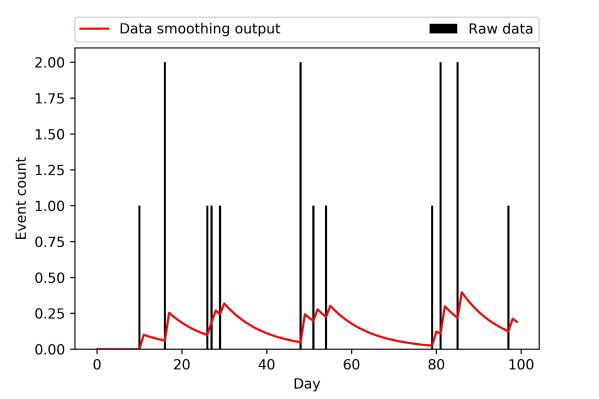

Source code for the `perform_exponential_smoothing()` function called below can be [found on GitHub](https://github.com/subelsky/crimegraph).

In [22]:
from lib.events import perform_exponential_smoothing

smoothing_factor = 0.5
smoothed_timesteps = perform_exponential_smoothing(timesteps, smoothing_factor)

## Sanity Check the Smoothing Algorithm

When we try to re-create the plot from the paper, we see a problem. Our smoothed values decay very slowly:

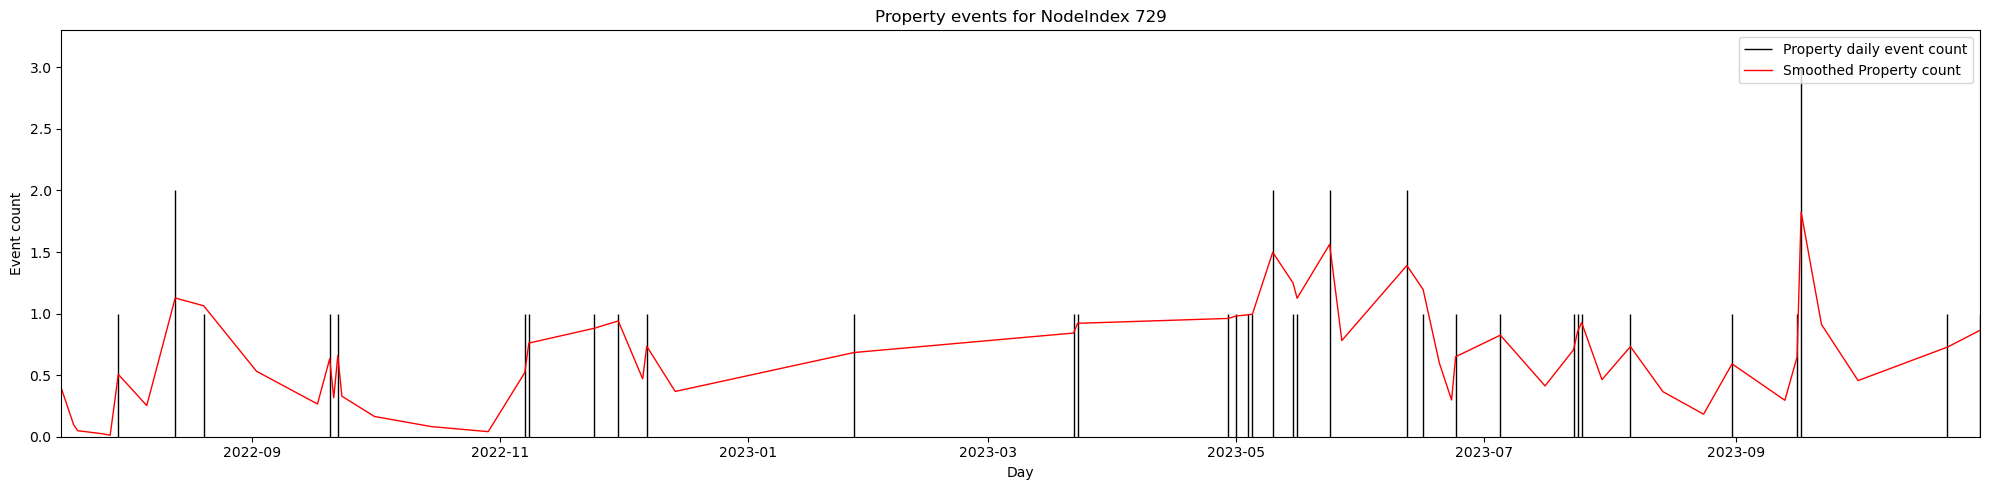

In [23]:
#| code-fold: true
from lib.plots import plot_event_counts

plot_event_counts(smoothed_timesteps, 729, 'Property', num_days=60)

## Analyze the Problem

I tried many values for the `alpha` smoothing factor, but the same pattern persisted. I eventually realized that the timesteps dataframe is itself sparse: because there are no zero values for dates when there are no crimes, the smoothing function directly interpolates between events separated by many timesteps.

The fix was to add zero values to the events dataframe for any missing dates^[I tried using more sophisticated methods that would save memory without needing to materialize so many empty rows, but couldn't get things working correctly. In the interest of time, I decided to use this brute-force approach] so that the smoothing function could decay to zero between events separated by many timesteps.

## Add Zero Event Timesteps

In [24]:
from lib.events import interpolate_and_smooth

interpolated_smoothed_timesteps = interpolate_and_smooth(timesteps, 0.5)

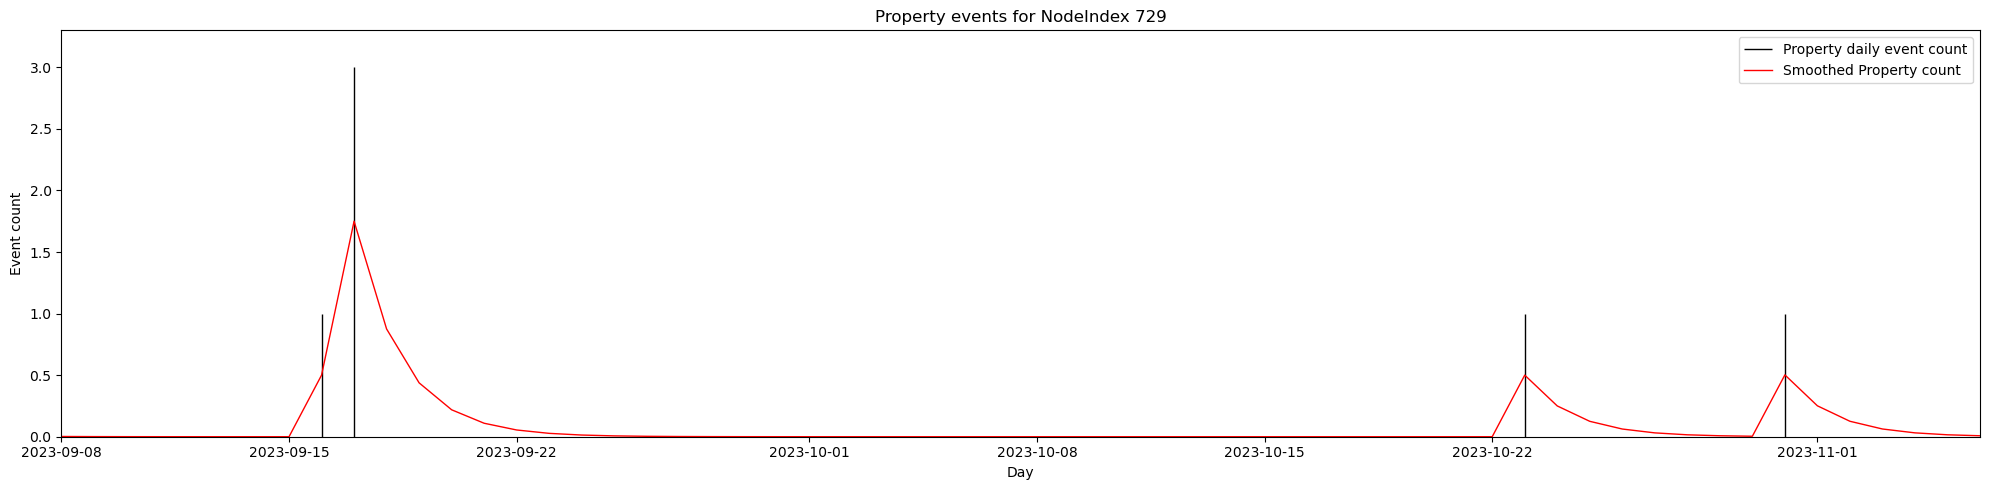

In [25]:
#| code-fold: true
from lib.plots import plot_event_counts

plot_event_counts(interpolated_smoothed_timesteps, 729, 'Property', num_days=60)

That looks better. Note that the smoothing factor `0.5` was chosen arbitrarily through trial and error. The true value will need to be chosen via training experiments^[A process called Hyperparameter Optimization].

Here is a sample of the final dataframe to be used for training the model. Note that we are keeping the original columns so that the smoothing function can be run again during those experiments:

In [26]:
#| code-fold: true
interpolated_smoothed_timesteps

,Type,Arrest,Property,Violent,ArrestSmoothed,PropertySmoothed,ViolentSmoothed
Date,NodeIndex,,,,,,
2015-01-01,0,0.0,0.0,2.0,0.0,0.000000e+00,2.000
2015-01-02,0,0.0,0.0,0.0,0.0,0.000000e+00,1.000
2015-01-03,0,0.0,0.0,0.0,0.0,0.000000e+00,0.500
2015-01-04,0,0.0,0.0,0.0,0.0,0.000000e+00,0.250
2015-01-05,0,0.0,0.0,0.0,0.0,0.000000e+00,0.125
...,...,...,...,...,...,...,...
2023-11-02,687,0.0,0.0,0.0,0.0,8.077936e-28,0.000
2023-11-03,687,0.0,0.0,0.0,0.0,4.038968e-28,0.000
2023-11-04,687,0.0,0.0,0.0,0.0,2.019484e-28,0.000


## Saving Our Work

As in part 1, we save the timesteps to disk for use when training the model. We also save the events data, in case we want to use it for future experiments.

In [27]:
smoothed_timesteps.to_csv('../../data/processed/timesteps.csv.gz', compression='gzip')
events_with_nodes_gdf.to_file('../../data/processed/events_with_nodes_gdf.geojson', driver='GeoJSON')

## Up Next {.unnumbered}

We're finally ready to start building a basic `GLDnet` model - stay tuned for part 3!